We load in the model that we trained before and train a GAN with that as a starting point.

In [1]:
!~/.local/bin/megaget /Root/Datasets/SuperRes/Images/highres-2000.tar.gz --path /home/ubuntu --username jamesjuanwhei.tan@taylorssj.com --password omdenafwp



Downloaded highres-2000.tar.gz33;1m99.96% - 3.3 GiB (3491111824 bytes) of 3.3 GiB (4.0 MiB/s)0KK


### IMPORTS

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *
from torchvision.models import vgg16_bn

### PATHS

In [2]:
# #Change this to where your images are
# path = Path('/home/ubuntu/NepalImages')
# path_hr= path/'cropped_into_4'

# #its fine to define a path to something that doesn't exist
# path_lr = path/'cropped_into_4_96'

In [11]:
#Change this to where your images are
path = Path('/home/ubuntu/NepalImages')
path_hr= path/'cropped-600'

#its fine to define a path to something that doesn't exist
#path_lr = path/'cropped_into_4_96'
path_lr = path/'cropped-100'

In [3]:
# !~/.local/bin/megaget /Root/Datasets/SuperRes/Models/cropped_100/export.pkl --path {path_cropped_100/'export.pkl'} --username jamesjuanwhei.tan@taylorssj.com --password omdenafwp



### Loading Generator

In [16]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

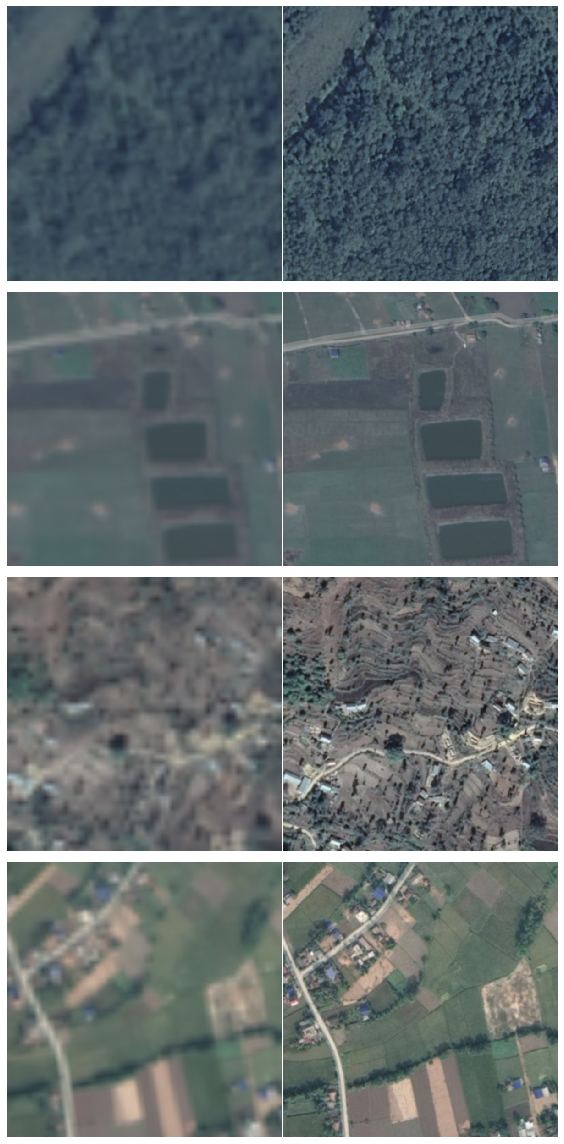

In [17]:
bs,size=5,600

data_gen = get_data(bs,size)
data_gen.show_batch(4)

In [18]:
# learn = unet_learner(data_gen , models.resnet34, wd=1e-3, loss_func=MSELossFlat(),
#                      blur=True, norm_type=NormType.Weight)

In [19]:
# learn.load('2b');

In [20]:
path_cropped_100 = path/'cropped-100'

In [21]:
learn = load_learner(path_cropped_100)
learn.data = data_gen

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.vision.models.unet.UnetBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.PixelShuffle_ICNR' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.MergeLayer' has changed. you can retrieve the original source code by accessing the obje

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


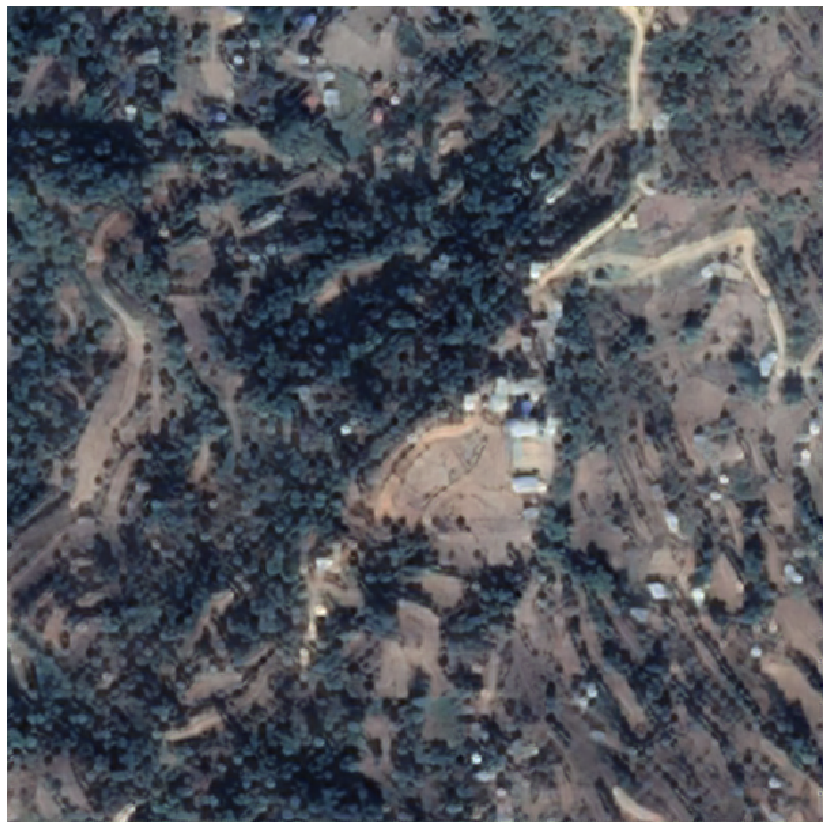

In [22]:
img = open_image(path_lr.ls()[0]); img.shape
p,img_hr,b = learn.predict(img)
Image(img_hr).show(figsize=(18,15))

### Save superres-ed images to a directory

In [23]:
name_gen = 'image_gen_600'
path_gen = path/name_gen
# shutil.rmtree(path_gen)
path_gen.mkdir(exist_ok=True)

In [24]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [25]:
save_preds(data_gen.fix_dl)

### Train Critic

In [7]:
learn=None
gc.collect()

16992

In [8]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [9]:
data_crit = get_crit_data([name_gen, 'cropped_into_4_96'], bs=20, size=256)

NameError: name 'name_gen' is not defined

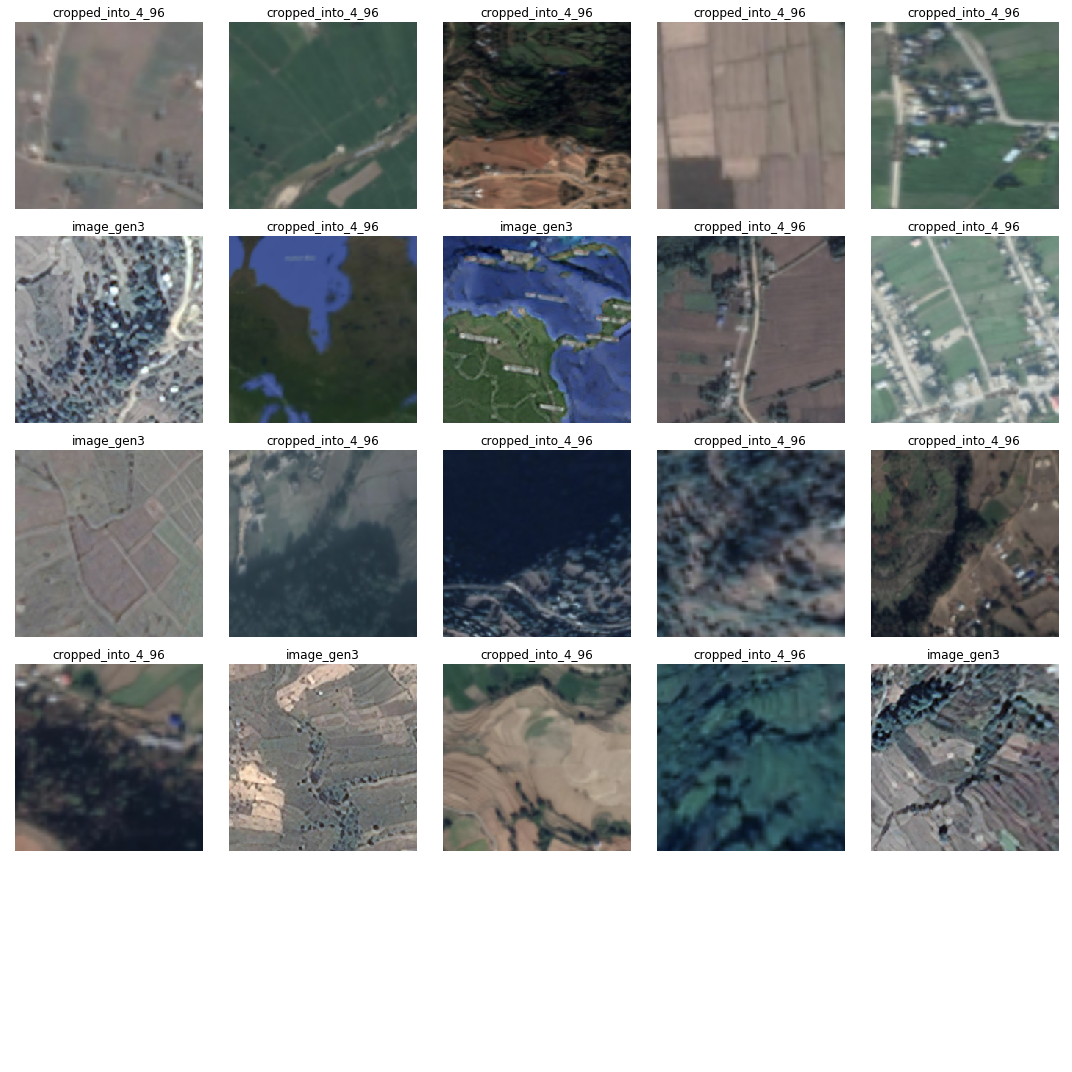

In [10]:
data_crit.show_batch(rows=5, ds_type=DatasetType.Train, imgsize=3)

In [10]:
wd = 1e-3
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [11]:
learn_critic=None
gc.collect()

0

In [13]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pretrained-3')

# GAN

In [12]:
learn_crit=None
learn_gen=None
gc.collect()

0

In [13]:
bs,size=2,256

In [14]:
data_crit = get_crit_data(['cropped_into_4_96', 'cropped_into_4'], bs=bs, size=size)

In [15]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pretrained-3')

In [16]:
# learn_gen = unet_learner(data_gen, models.resnet34, wd=1e-3, loss_func=MSELossFlat(),
#                      blur=True, norm_type=NormType.Weight).load('2b');

In [17]:
learn_gen  = load_learner(path_cropped_100)
learn_gen.data = data_gen

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.vision.models.unet.UnetBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.PixelShuffle_ICNR' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.MergeLayer' has changed. you can retrieve the original source code by accessing the obje

# Feature Loss

In [18]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
base_loss = F.l1_loss

In [19]:
learn_gen.loss_func = feat_loss

In [20]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [21]:
lr = 1e-4

In [ ]:
learn.fit(20,lr)

learn_gen.save('gan-gen-1')
learn_crit.save('gan-crit-1')

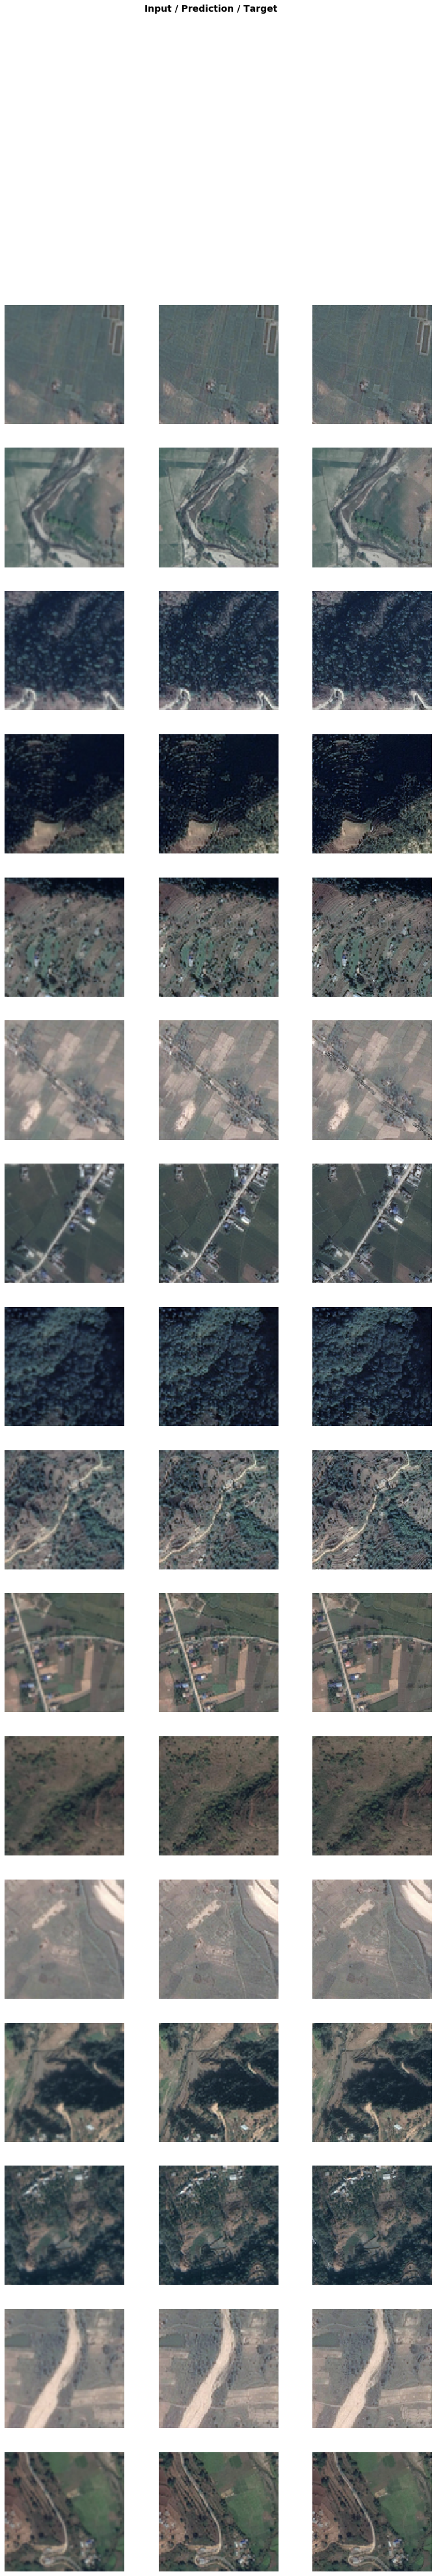

In [37]:
learn.show_results(rows=16)

In [26]:
learn.data=get_data(5,300)

In [27]:
learn.fit(10,lr/2)

In [28]:
learn.save('gan-2')

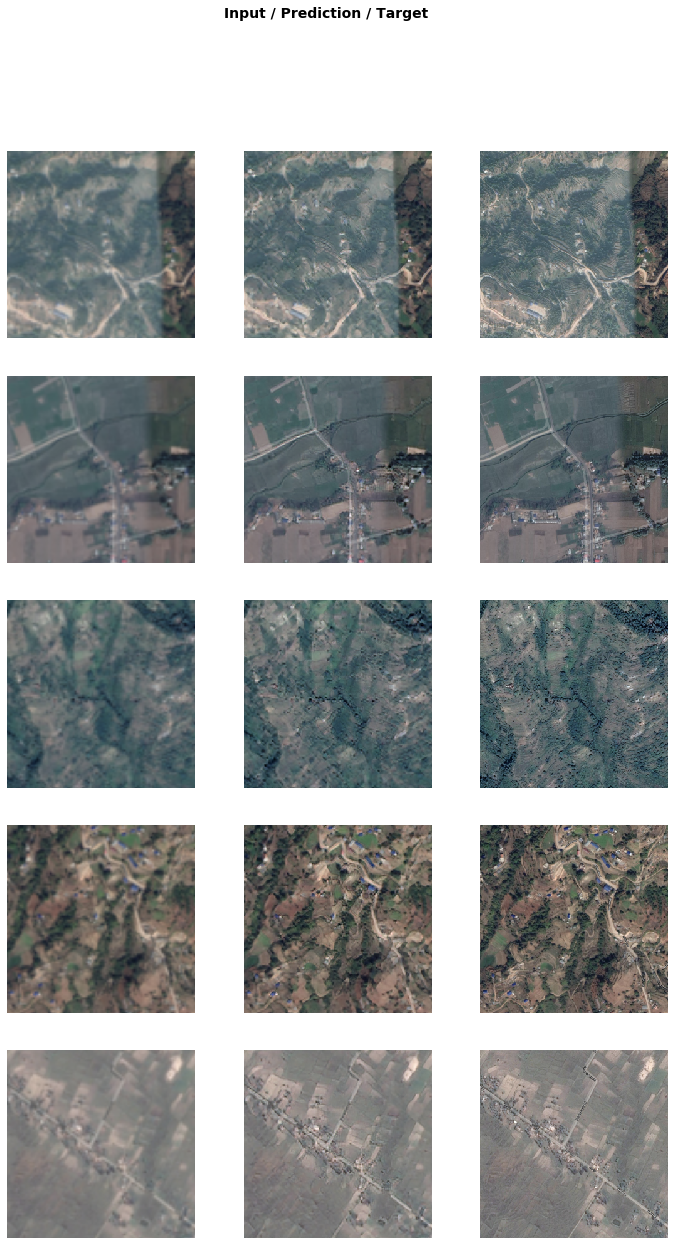

In [29]:
learn.show_results(rows=5)

In [66]:
learn.data=get_data(5,450)

In [ ]:
learn.fit(10,lr/4)

# Train with Feature Loss

In [ ]:
learn.fit(20,lr)

learn_gen.save('gan-gen_v4-1')
learn_crit.save('gan-gen_v4-1')

# Inference

In [35]:
learn.show_results??

In [44]:
img = open_image('test_scale_1-2.tif')

In [60]:
img2 = open_image('deepimageprior_3kiters.jpg')

In [57]:
learn.data = get_data(1,500)

In [58]:
res = learn.predict(img)

In [61]:
pred2 = learn.predict(img2)

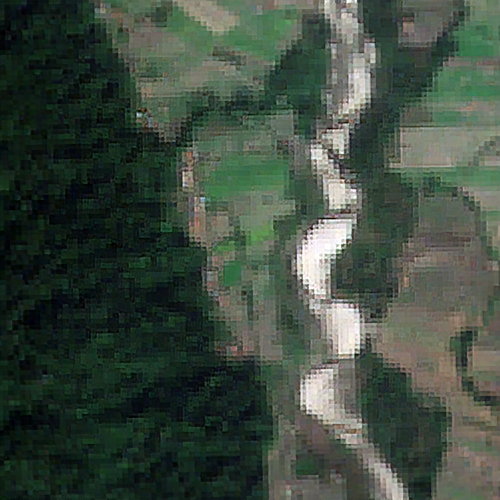

In [64]:
res[0]

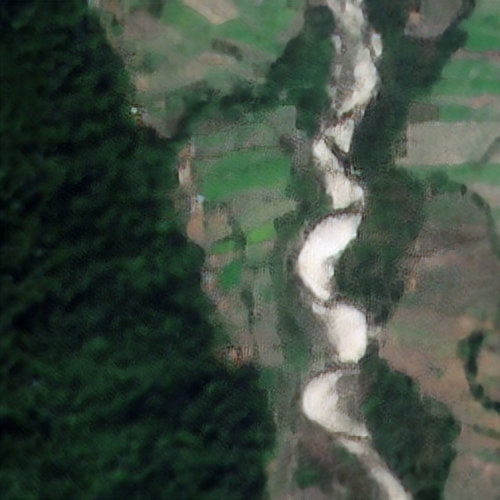

In [62]:
pred2[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


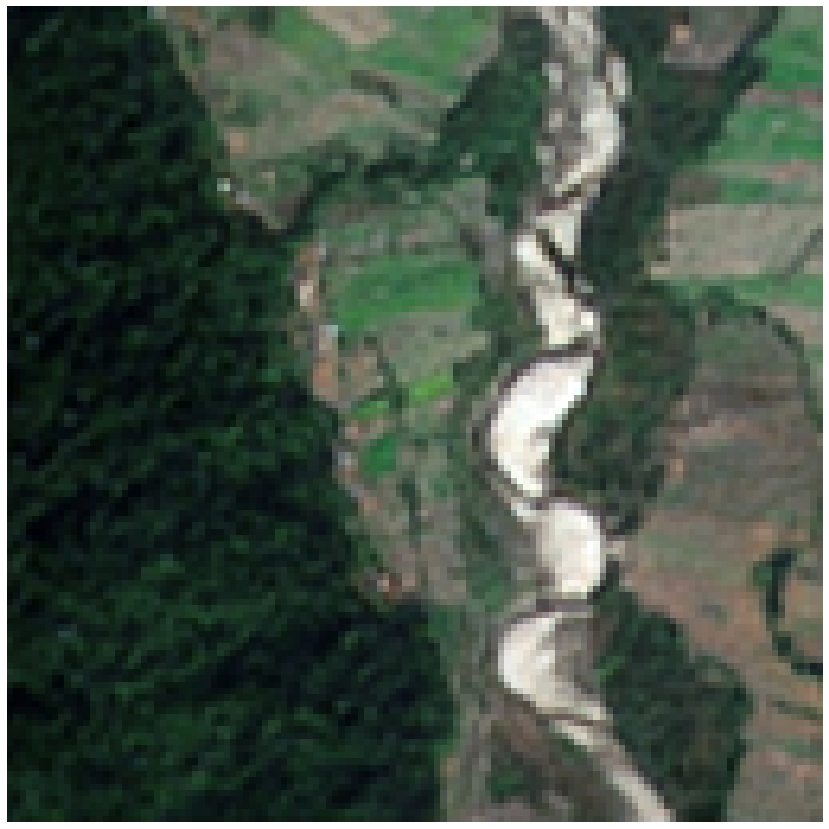

In [38]:
img = open_image('deepimageprior_3kiters.jpg'); img.shape
p,img_hr,b = learn_gen.predict(img)
Image(img_hr).show(figsize=(18,15))